## Introduction

* The anchor-word algorithm is from [Practical Correlated Topic Modeling and Analysis via the Rectified Anchor Word Algorithm](https://moontae.people.uic.edu/papers/pdfs/Moontae_Lee-EMNLP2019.pdf). 

* I want to see how anchor-word algo works on a more realistically simulated dataset: I fit the  [sla dataset](https://zihao12.github.io/ebpmf_data_analysis/data_preprocessing_sla) with `fastTopics`. Then I use the fitted multinomial model to generate simulated data. I can change the document length to make the estimation problem easier or harder. 


## results

* Directly fitted on the simuated data gets very bad results, whereas MLE can recover $F$ very well ($\hat{L}$ is worse as it's probably a harder problem). The problem is poor $\hat{C}$

* Using true $C$, we can get almost perfect result (this also implies anchor-word assumption is satisfied)

* However, when I increase the document length by only 3 times, we can get relatively good estimate of $F$, even when $\hat{C}$ is still not good and the identified anchor-words are wrong! But the estimate of $A$ is not very good (so $L$ would be even worse)

* Therefore when either the document length is long, or there are many many documents, we can expect better estimate of $C$ and good estimate of $F$. Also how to improve estimate of $C$ can be quite an important problem for anchor-word type of methods. 


In [1]:
import os
import sys
import pandas as pd
from scipy import sparse
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import mmread
script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions_anchor import *
from misc import *


np.random.seed(123)

## sla-k6-rate1

matched topic idx
[2 1 0 3 4 5]
########## Compare A ############
### A ###
[[0.11 0.01 0.02 0.02 0.02 0.01]
 [0.01 0.08 0.02 0.01 0.01 0.01]
 [0.02 0.02 0.14 0.02 0.02 0.02]
 [0.02 0.01 0.02 0.12 0.01 0.01]
 [0.02 0.01 0.02 0.01 0.08 0.01]
 [0.01 0.01 0.02 0.01 0.01 0.07]]
[0.19 0.14 0.23 0.18 0.14 0.11]
### Afit ###
[[0.21 0.   0.   0.   0.   0.  ]
 [0.   0.1  0.   0.   0.   0.  ]
 [0.   0.   0.36 0.   0.   0.  ]
 [0.   0.   0.   0.08 0.   0.  ]
 [0.   0.   0.   0.   0.13 0.  ]
 [0.   0.   0.   0.   0.   0.1 ]]
[0.21 0.1  0.36 0.08 0.13 0.1 ]
########## anchor rows ############
B[S,:]
[[0.e+00 0.e+00 2.e-05 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-05 0.e+00 0.e+00 0.e+00 0.e+00]
 [2.e-05 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-05 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 1.e-05 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 2.e-05]]
Ftrue[S,:]
[[4.0e-05 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 5.0e-05 0.0e+00 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 3.0e

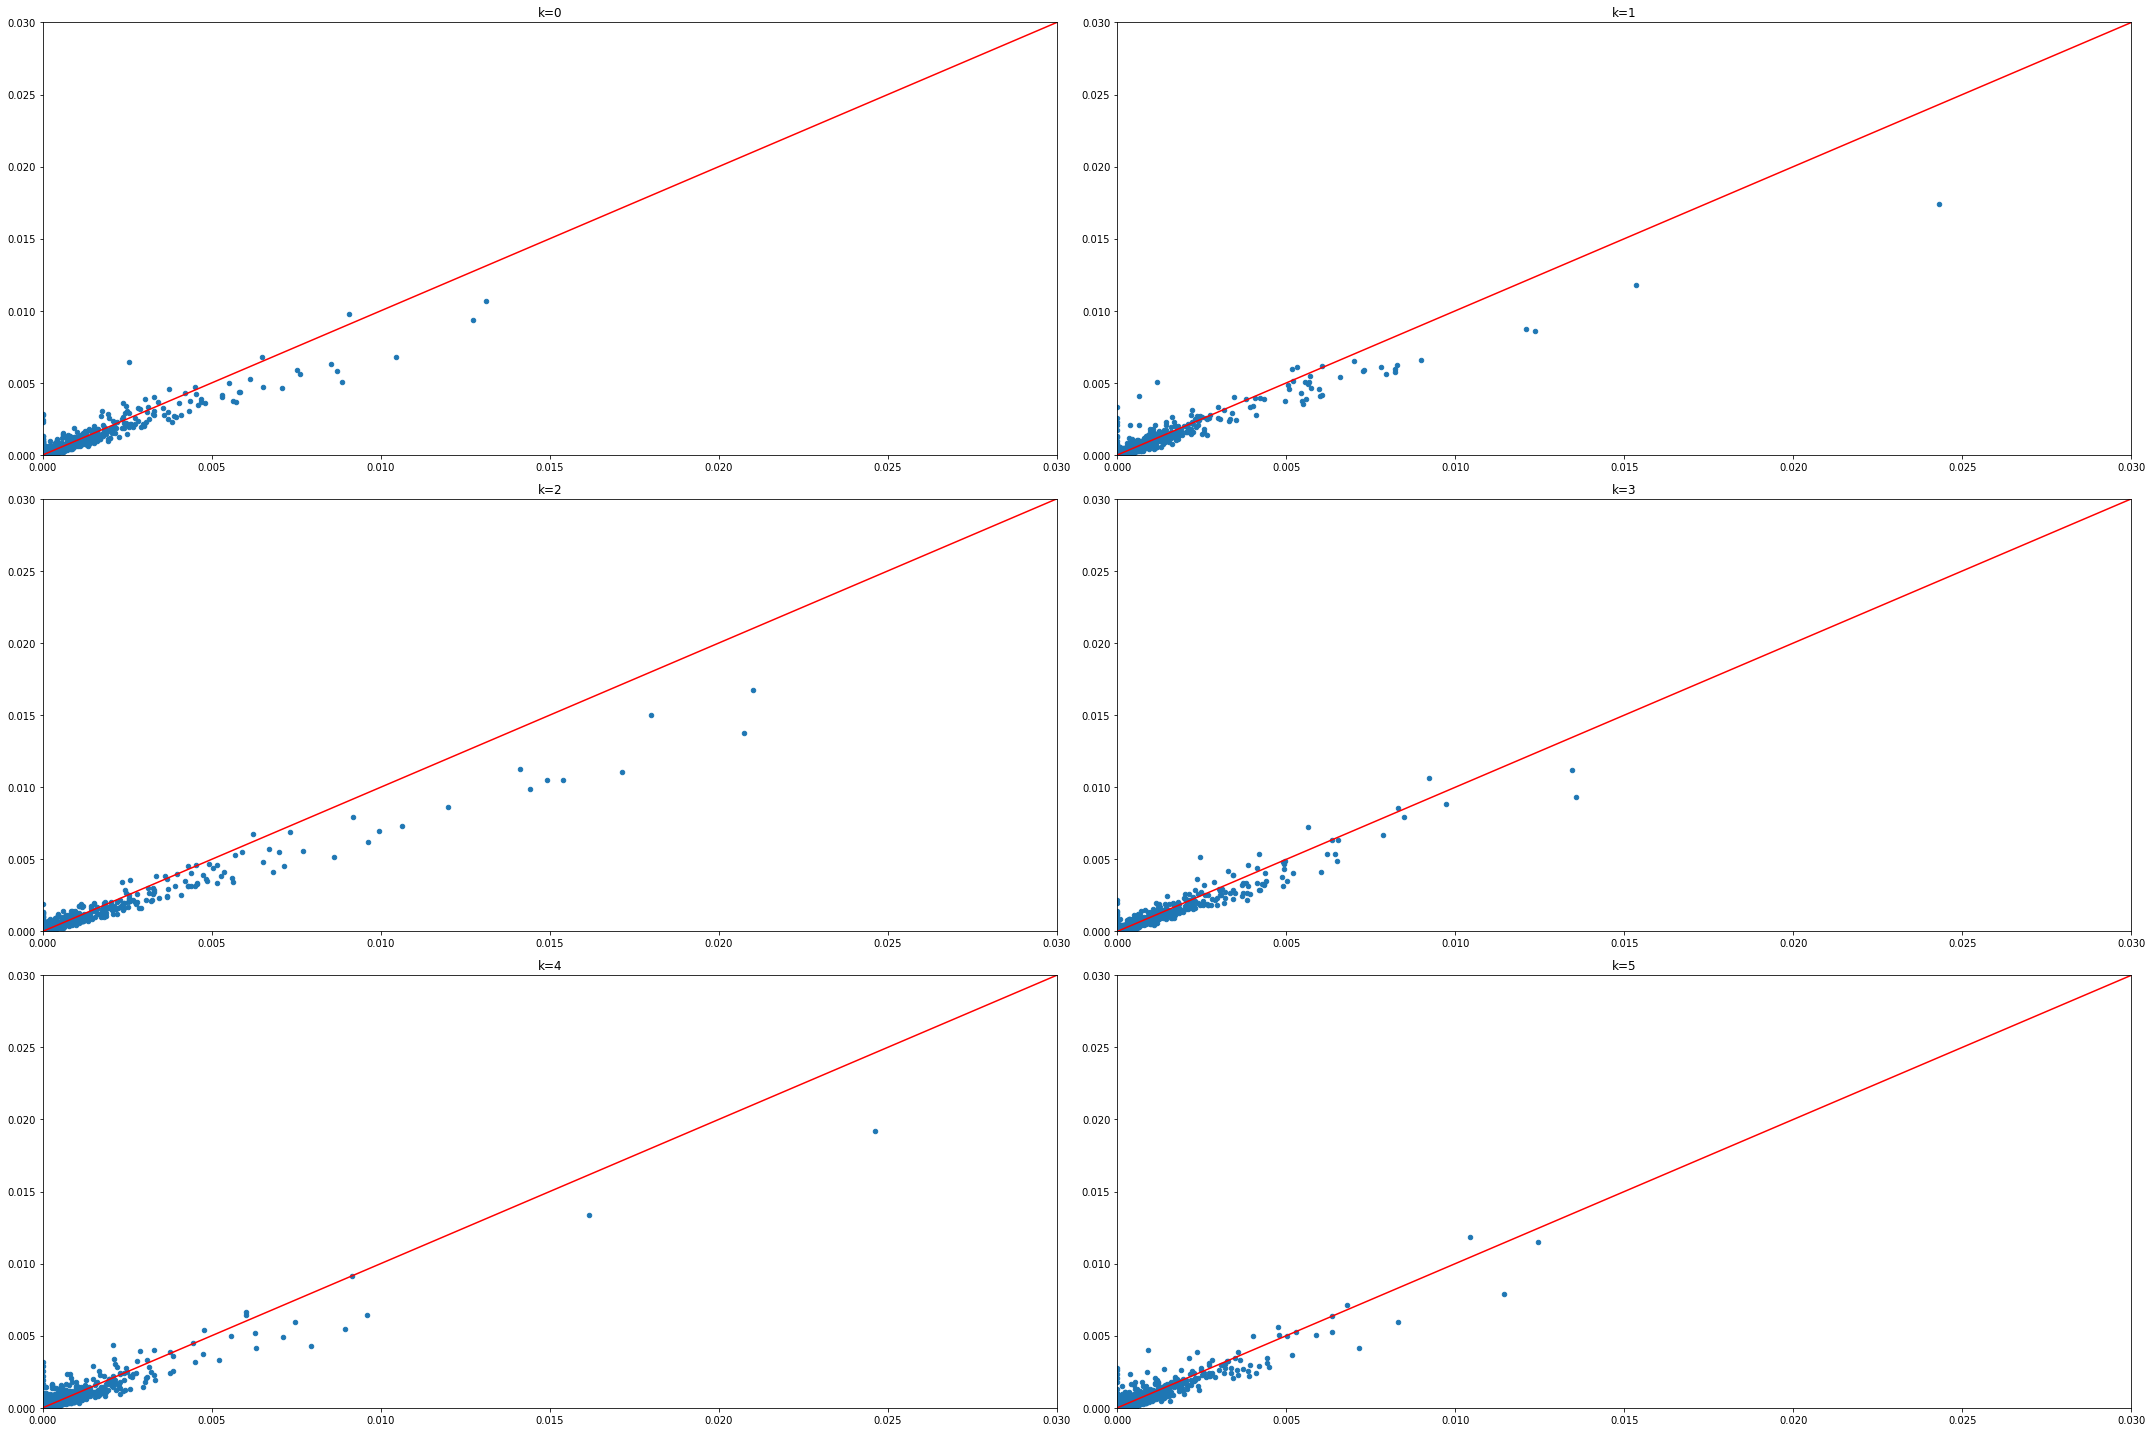

In [2]:
## load data
dataname = "sla"
k = 6
rate=1

datafile=f"output/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)


idx = match_topics(fitted['Ftrue'],fitted['B']).astype(int)
print("matched topic idx")
print(idx)

print("########## Compare A ############")
print("### A ###")
print(fitted['Atrue'].round(2))
print(fitted['Atrue'].sum(axis = 0).round(2))
print("### Afit ###")
print(fitted['A'][np.ix_(idx, idx)].round(2))
print(fitted['A'][np.ix_(idx, idx)].sum(axis = 0).round(2))

print("########## anchor rows ############")
S = fitted["S"]
S0 = fitted["S0"]
print("B[S,:]")
print(fitted["B"][S[idx],:].round(5))
print("Ftrue[S,:]")
print(fitted["Ftrue"][S[idx],:].round(5))
print("Ftrue[S0,:]")
print(fitted["Ftrue"][S0,:].round(5))


print("########## Compare F ############")
n_row = int(k/2)

fig, axes = plt.subplots(n_row, 2, figsize = (30, 20))
custom_xlim = (0, 0.03)
custom_ylim = (0, 0.03)

# Setting the values for all axes.
plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)
for i in range(n_row):
    j = 2*i
    axes[i, 0].scatter(fitted['Ftrue'][:, j], fitted['B'][:, idx[j]], s = 20)
    axes[i, 0].plot(custom_xlim, custom_ylim, 'k-', color = "red")
    axes[i, 0].set_title(f'k={j}')
    j += 1
    axes[i, 1].scatter(fitted['Ftrue'][:, j], fitted['B'][:, idx[j]], s = 20)
    axes[i, 1].plot(custom_xlim, custom_ylim, 'k-', color = "red")
    axes[i, 1].set_title(f'k={j}')

plt.tight_layout()
plt.show()